In [35]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")

In [36]:
df = pd.read_csv('../cleaned_data/ratings_small.csv')
movies_df = pd.read_csv('../cleaned_data/movies_small.csv', usecols=['movie_id', 'title', 'img_url'])

In [37]:
def get_movie_url(movie_id):
    return movies_df[movies_df.movie_id == movie_id].img_url.values[0]

In [38]:
def get_user_id(user_id_number):
    return df[df.user_id_number == user_id_number].user_id.values[0]

def get_movie_id(movie_id_number):
    return df[df.movie_id_number == movie_id_number].movie_id.values[0]

In [39]:
class CF(object):
    """docstring for CF"""
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k # number of neighbor points
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1

    def add(self, new_data):
        """
        Update Y_data matrix when new ratings come.
        For simplicity, suppose that there is no new user or item.
        """
        self.Y_data = np.concatenate((self.Y_data, new_data), axis = 0)

    def normalize_Y(self):
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1]
            # and the corresponding ratings
            ratings = self.Y_data[ids, 2]
            # take mean
            m = np.mean(ratings)
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important
        # for both memory and computing efficiency. For example, if #user = 1M,
        # #item = 100k, then shape of the rating matrix would be (100k, 1M),
        # you may not have enough memory to store this. Then, instead, we store
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)

    def refresh(self):
        """
        Normalize data and calculate similarity matrix again (after
        some few ratings added)
        """
        self.normalize_Y()
        self.similarity()

    def fit(self):
        self.refresh()

    def __pred(self, u, i, normalized = 1):
        """
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        # Step 2:
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 3: find similarity btw the current user and others
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:]
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]


    def pred(self, u, i, normalized = 1):
        """
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)

    def recommend(self, u, normalized = 1):
        """
        Determine all items should be recommended for user u. (uuCF =1)
        or all users who might have interest on item u (uuCF = 0)
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which
        have not been rated by u yet.
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0:
                    recommended_items[i] = rating

        return sorted(recommended_items, key=recommended_items.get, reverse=True)


    def print_recommendation(self, u, number=10):
        """
        Print all items which should be recommended for each user.
        """
        print('Recommendation: ')
        recommended_items = self.recommend(u)
        recommended_items = recommended_items[:number]

        if self.uuCF:
            print(f'Recommended movie(s) for user {get_user_id(u)} : {recommended_items}')

            cols = 5 if number > 5 else number
            rows = math.ceil(number/cols)

            fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
            urls = []

            for i in recommended_items:
                movie_id = df[df.movie_id_number == i].movie_id.values[0]
                urls.append(get_movie_url(movie_id))

            for i, ax in enumerate(axes.flat):
                if i < number:
                    ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                    fig.tight_layout()
                    ax.axis('off')
                else:
                    ax.axis('off')

        else:
            movie_id = df[df.movie_id_number == u].movie_id.values[0]
            url = get_movie_url(movie_id)
            print('Recommend movie', get_movie_id(u), 'to user(s) : ', recommended_items)
            plt.imshow(np.array(Image.open(urllib.request.urlopen(url))))
            plt.axis('off')

In [40]:
df['user_id_number'] = df['user_id'].astype('category').cat.codes.values
df['movie_id_number'] = df['movie_id'].astype('category').cat.codes.values

In [41]:
df = df.groupby('user_id').filter(lambda x : len(x) >= 20)
df = df.groupby('movie_id').filter(lambda x : len(x) >= 10)
df = df[df['rating'] >= 3]

In [42]:
Y_data = df[['user_id_number', 'movie_id_number', 'rating']].values

## User-based Collaborative Filtering

Recommendation: 
Recommended movie(s) for user ur64798417 : [4924, 8968, 8291, 22093, 8198, 6115, 24646, 18414, 8664, 2969, 5233, 22972, 14955, 26693, 2868, 2486, 2342, 12815]


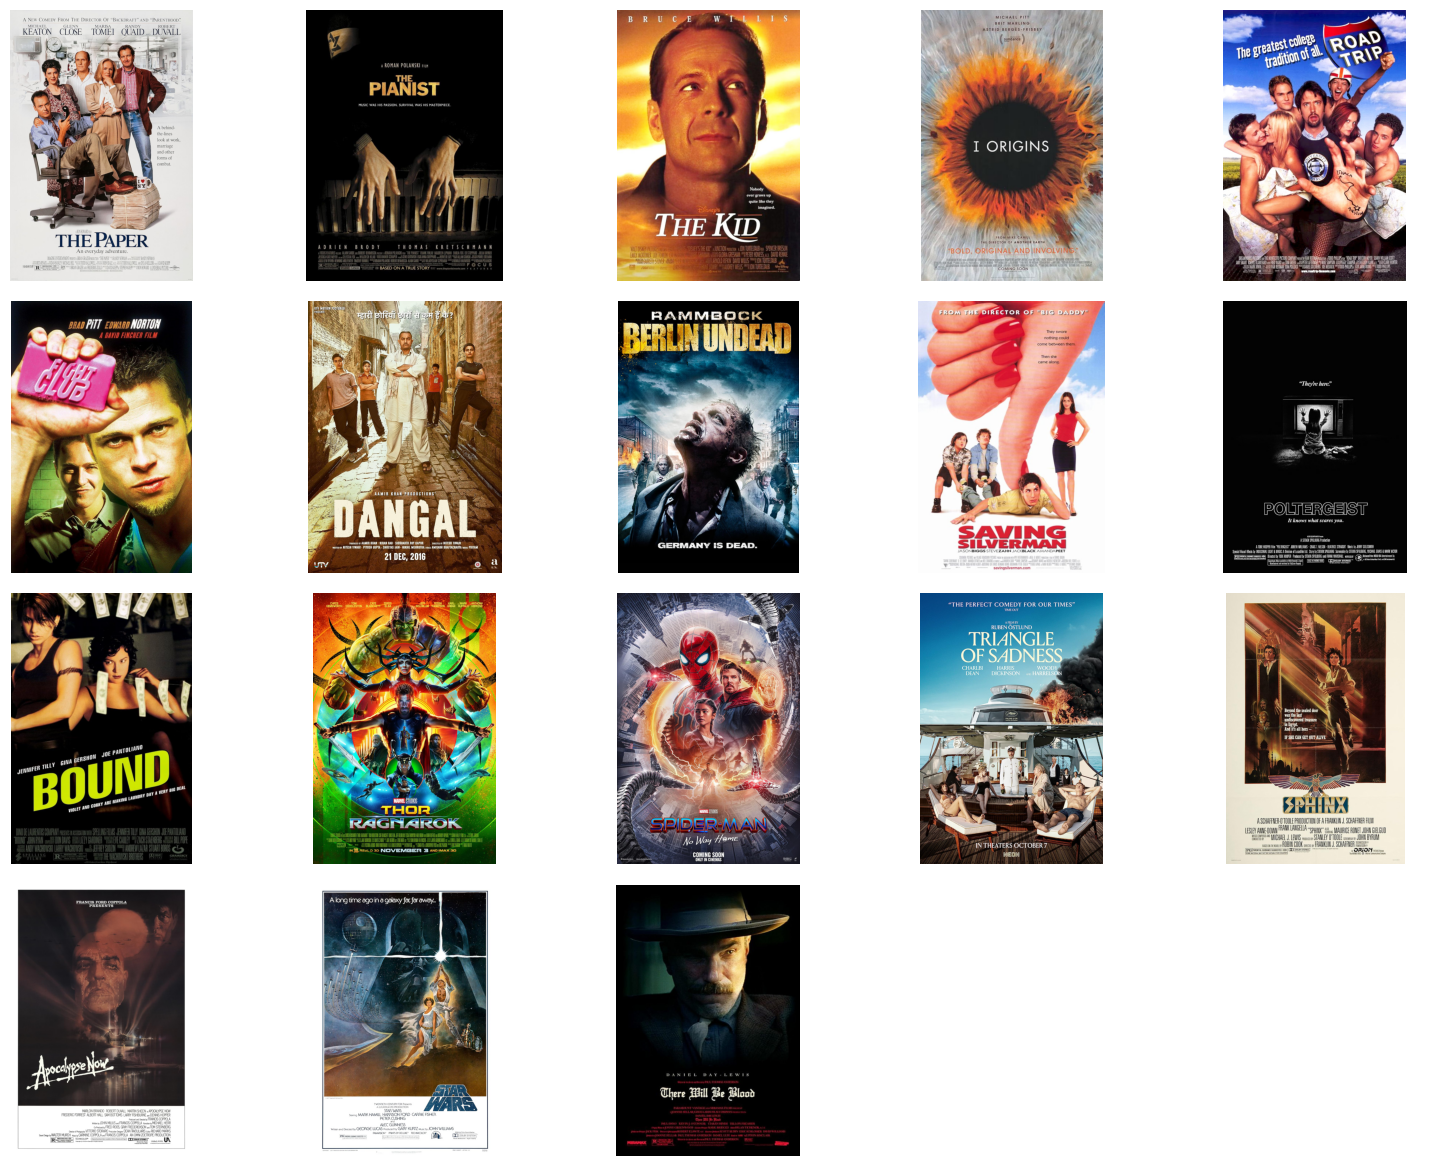

In [43]:
user_based_cf = CF(Y_data, k = 5, uuCF = 1)
user_based_cf.fit()
user_id = 'ur64798417'
# convert user_id to user_id_number
user_id_number = df[df.user_id == user_id].user_id_number.values[0]
user_based_cf.print_recommendation(user_id_number, number=18)

## Item-based Collaborative Filtering

Recommendation: 
Recommend movie tt0477348 to user(s) :  [49670, 9557, 19952, 70375, 38042, 4701, 12939, 69279, 44970, 28305]


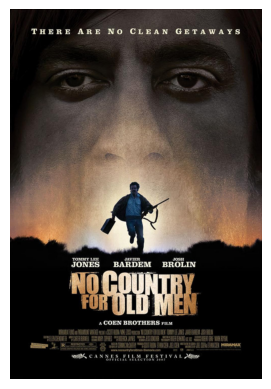

In [44]:
item_based_cf = CF(Y_data, k = 5, uuCF = 0)
item_based_cf.fit()
movie_id = 'tt0477348'
movie_id_number = df[df.movie_id == movie_id].movie_id_number.values[0]
item_based_cf.print_recommendation(movie_id_number)